# EEG Seizure Detection: EDA & Preprocessing Analysis

This notebook provides a comprehensive exploratory data analysis (EDA) of the CHB-MIT EEG dataset and validates the preprocessing pipeline.

### Objectives:
1. **Class Imbalance**: Analyze the distribution of seizure vs. normal segments.
2. **Signal Visualization**: Compare raw EEG signals with their processed counterparts.
3. **Preprocessing Validation**: Demonstrate the effectiveness of Notch and Bandpass filters using Power Spectral Density (PSD).

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

# Add src to path
sys.path.append(str(Path(os.getcwd()).parent))

from src.data.preprocess import load_eeg_data, TARGET_CHANNELS
from src.data.dataset import parse_summary
from src.utils.config import load_config

# Plotting config
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load Configuration & Statistics

We use the centralized `config.yaml` to identify the data directories and subjects.

In [2]:
cfg = load_config("../config.yaml")
raw_dir = Path("../") / cfg.data.raw_dir
subjects = cfg.data.subjects

print(f"Raw Data Directory: {raw_dir}")
print(f"Number of Subjects: {len(subjects)}")

Raw Data Directory: ..\data\raw\chbmit
Number of Subjects: 18


## 2. Class Imbalance Analysis

We parse the summary files to count the total duration of seizure vs. normal recordings.

### 2.1 Total Case Counts Summary

This bar chart provides a direct comparison between the total number of normal segments and seizure segments in the dataset.

C:\Users\yusuf\AppData\Local\Temp\ipykernel_7744\3874166622.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Normal', 'Seizure'], y=[total_normal_segs, total_seizure_segs], palette=['#3498db', '#e74c3c'])


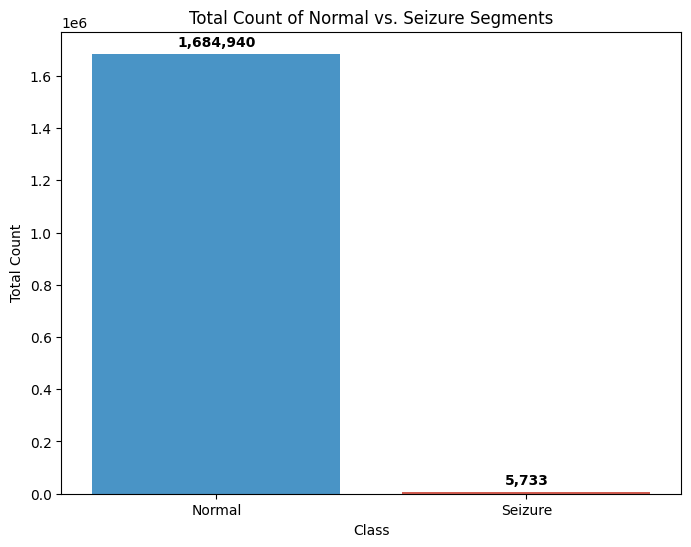

In [3]:
# Plotting the total counts for normal vs. seizure segments
plt.figure(figsize=(8, 6))
sns.barplot(x=['Normal', 'Seizure'], y=[total_normal_segs, total_seizure_segs], palette=['#3498db', '#e74c3c'])
plt.title('Total Count of Normal vs. Seizure Segments')
plt.ylabel('Total Count')
plt.xlabel('Class')

# Add labels on top of bars
for i, count in enumerate([total_normal_segs, total_seizure_segs]):
    plt.text(i, count + (total_normal_segs * 0.01), f"{count:,}", ha='center', va='bottom', fontweight='bold')

plt.show()

### 2.2 Segment-Level Class Imbalance

The model is trained on individual segments. Here we calculate and visualize the total count of normal and seizure segments across all processed subjects.

Total Normal Segments: 1,684,940
Total Seizure Segments: 5,733
Ratio: 1 Seizure segment per 293.9 Normal segments


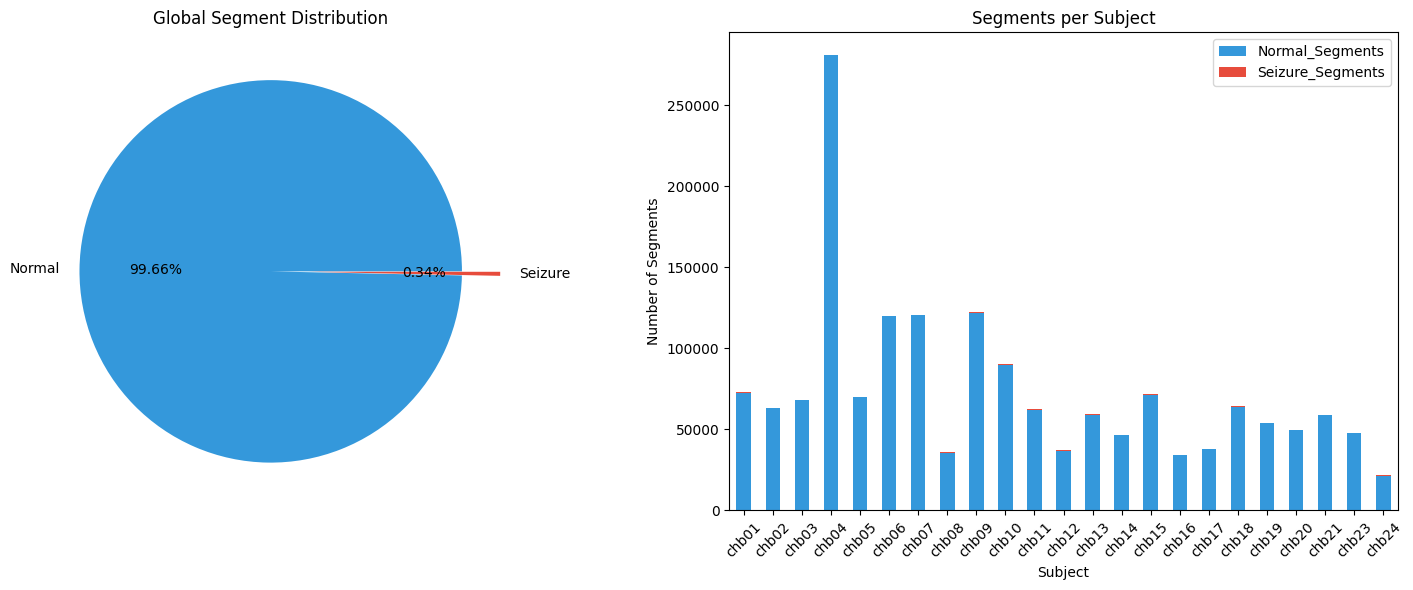

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate segment-level statistics
processed_dir = Path('../data/processed')
subjects = [d.name for d in processed_dir.iterdir() if d.is_dir()]

segment_stats = []
for subj in subjects:
    subj_dir = processed_dir / subj
    manifest_file = subj_dir / 'manifest.txt'
    if not manifest_file.exists():
        continue
        
    with open(manifest_file, 'r') as f:
        stems = f.read().splitlines()
        
    sz_total = 0
    normal_total = 0
    for stem in stems:
        labels = np.load(subj_dir / f"{stem}_labels.npy")
        sz_count = int(labels.sum())
        sz_total += sz_count
        normal_total += (len(labels) - sz_count)
        
    segment_stats.append({
        'Subject': subj,
        'Normal_Segments': normal_total,
        'Seizure_Segments': sz_total,
        'Total_Segments': normal_total + sz_total
    })

df_seg_stats = pd.DataFrame(segment_stats).sort_values('Subject')

# 2. Visualize global distribution
total_normal_segs = df_seg_stats['Normal_Segments'].sum()
total_seizure_segs = df_seg_stats['Seizure_Segments'].sum()
print(f"Total Normal Segments: {total_normal_segs:,}")
print(f"Total Seizure Segments: {total_seizure_segs:,}")
if total_seizure_segs > 0:
    print(f"Ratio: 1 Seizure segment per {total_normal_segs/total_seizure_segs:.1f} Normal segments")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Global pie chart
ax1.pie([total_normal_segs, total_seizure_segs], labels=['Normal', 'Seizure'], 
        autopct='%1.2f%%', colors=['#3498db', '#e74c3c'], explode=[0, 0.2])
ax1.set_title("Global Segment Distribution")

# Subject-wise stacked bar plot
df_seg_stats.set_index('Subject')[['Normal_Segments', 'Seizure_Segments']].plot(
    kind='bar', stacked=True, ax=ax2, color=['#3498db', '#e74c3c']
)
ax2.set_title("Segments per Subject")
ax2.set_ylabel("Number of Segments")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3. Signal Preprocessing Comparison

We take a sample EEG segment and compare the raw signal with the filtered signal (1-45Hz Bandpass + 50Hz Notch).

C:\Users\yusuf\AppData\Local\Temp\ipykernel_17044\4141521002.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_mne = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)
d:\work\freelance\eeg-biometric-system\src\data\preprocess.py:121: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True, verbose=verbose)


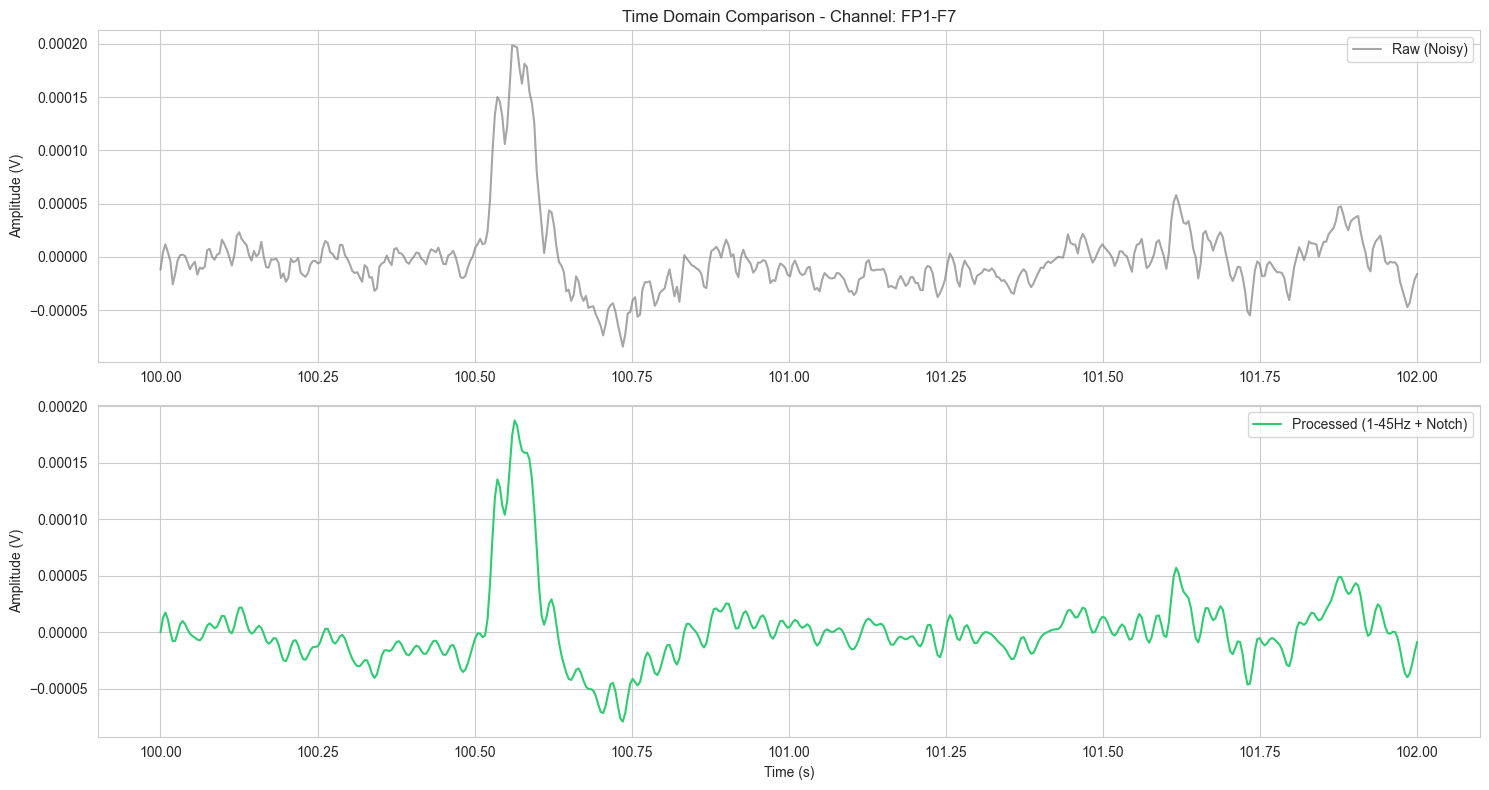

In [4]:
# Load a sample file (Subject 1, first file)
sample_subj = subjects[0]
sample_file = list((raw_dir / sample_subj).glob("*.edf"))[0]

# Load Raw (using MNE directly to keep it truly raw)
raw_mne = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)
raw_mne.pick(TARGET_CHANNELS[:5]) # Pick first 5 channels for clarity
data_raw = raw_mne.get_data()
sfreq = raw_mne.info['sfreq']

# Load Processed using our pipeline
data_proc, _, _ = load_eeg_data(
    str(sample_file), 
    target_channels=TARGET_CHANNELS[:5], 
    notch_freq=50.0, 
    bandpass_low=1.0, 
    bandpass_high=45.0
)

# Visualization: Time Domain
start_sec, duration = 100, 2 # 2 seconds of data
start_idx = int(start_sec * sfreq)
end_idx = start_idx + int(duration * sfreq)
t = np.linspace(start_sec, start_sec + duration, end_idx - start_idx)

ch_idx = 0
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(t, data_raw[ch_idx, start_idx:end_idx], color='gray', alpha=0.7, label="Raw (Noisy)")
plt.title(f"Time Domain Comparison - Channel: {TARGET_CHANNELS[ch_idx]}")
plt.ylabel("Amplitude (V)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, data_proc[ch_idx, start_idx:end_idx], color='#2ecc71', label="Processed (1-45Hz + Notch)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.legend()
plt.tight_layout()
plt.show()

## 4. Spectral Analysis (PSD)

The Power Spectral Density clearly shows the suppression of the 50Hz power-line noise and the 1-45Hz band prioritization.

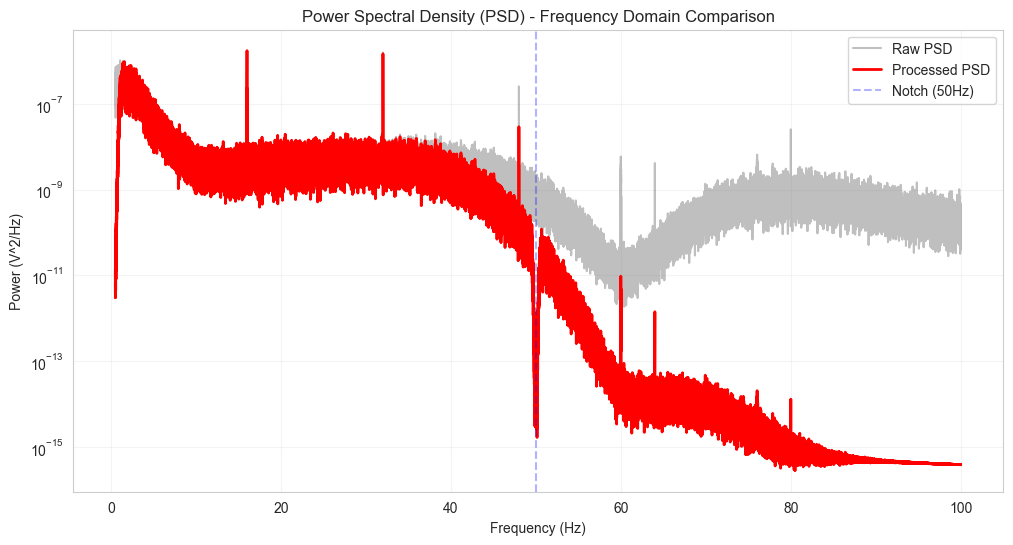

In [5]:
plt.figure(figsize=(12, 6))

# Raw PSD
psd_raw, freqs = mne.time_frequency.psd_array_multitaper(data_raw[ch_idx], sfreq, fmin=0.5, fmax=100, verbose=False)
plt.semilogy(freqs, psd_raw, color='gray', label='Raw PSD', alpha=0.5)

# Processed PSD
psd_proc, freqs = mne.time_frequency.psd_array_multitaper(data_proc[ch_idx], sfreq, fmin=0.5, fmax=100, verbose=False)
plt.semilogy(freqs, psd_proc, color='red', label='Processed PSD', linewidth=2)

plt.axvline(50, color='blue', linestyle='--', alpha=0.3, label='Notch (50Hz)')
plt.title("Power Spectral Density (PSD) - Frequency Domain Comparison")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (V^2/Hz)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()